In [64]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
import sklearn
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [12]:
#1. Get the data and get it ready to use (delete useless columns, change categories values)

df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')
df=df.drop(['video_id','video_id_court','channel_id','channel_name','Unnamed: 27'],axis=1)

'''
The categories-fields are useful data for us to analyse, 
but we cannot leave them as they are to compute a neural network algorithm.
We are then going to create one column for each value, and fill it with 0 or 1
'''

df['Core']=(df['categorie_new']=='Core')*1
df['Niche']=(df['categorie_new']=='Niche')*1
df['Partisan']=(df['categorie_new']=='Partisan')*1
df['Pure Players']=(df['categ_inst']=='Pure Players')*1
df['TV']=(df['categ_inst']=='TV')*1
df['Presse_regionale']=(df['categ_inst']=='Presse_regionale')*1
df['Presse nationale']=(df['categ_inst']=='Presse nationale')*1
df['Presse magazine']=(df['categ_inst']=='Presse magazine')*1
df['Alternatif']=(df['categ_inst']=='Alternatif')*1

df=df.drop(['categ_inst','categorie_new'],axis=1)

def convert_into_float(string):
    if type(string)==int:
        return string
    return float(string.replace(',','.'))

df=df.applymap(convert_into_float)

In [21]:
#2. Separate the train and the validation datasets
y=df['nbrMotInsulte'].to_numpy()
x=df.drop(['nbrMotInsulte'],axis=1).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(x, y)

In [22]:
#3. Feature Scaling
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
xtrain_scale=scaler_x.transform(X_train)
xval_scale=scaler_x.transform(X_val)
ytrain_scale=scaler_y.transform(y_train)
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [37]:
#4. Setting up the model
num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(hidden_layers, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_4 (Dense)              (None, 1536)              46080     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1537      
Total params: 48,487
Trainable params: 48,487
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Running the model
# We want to select the best couple (epoch, batch), so we test and compute the results for several different values
L_epoch=[30,50,100,200]
L_batch=[100,150,200,300,500]
History_dict={}
Prediction_dict={}
for epoch in L_epoch:
    History_dict[epoch]={}
    Prediction_dict[epoch]={}
    for batch in L_batch:
        model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
        history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=1, validation_split=0.2)
        predictions = model.predict(xval_scale)
        
        History_dict[epoch][batch]=history
        Prediction_dict[epoch][batch]=predictions

Epoch 1/30
277/277 [==============================] - 0s 1ms/step - loss: 5.3418e-07 - mse: 5.3418e-07 - mae: 3.0141e-04 - val_loss: 2.2578e-06 - val_mse: 2.2578e-06 - val_mae: 4.5334e-04
Epoch 2/30
277/277 [==============================] - 1s 2ms/step - loss: 8.0617e-07 - mse: 8.0617e-07 - mae: 3.5560e-04 - val_loss: 2.9394e-06 - val_mse: 2.9394e-06 - val_mae: 2.8332e-04
Epoch 3/30
277/277 [==============================] - 0s 1ms/step - loss: 5.2069e-07 - mse: 5.2069e-07 - mae: 2.9130e-04 - val_loss: 1.5131e-06 - val_mse: 1.5131e-06 - val_mae: 3.0579e-04
Epoch 4/30
277/277 [==============================] - 0s 1ms/step - loss: 6.1306e-07 - mse: 6.1306e-07 - mae: 3.1202e-04 - val_loss: 2.6128e-06 - val_mse: 2.6128e-06 - val_mae: 3.7744e-04
Epoch 5/30
277/277 [==============================] - 0s 1ms/step - loss: 8.0110e-07 - mse: 8.0110e-07 - mae: 3.3296e-04 - val_loss: 7.4828e-06 - val_mse: 7.4828e-06 - val_mae: 4.4610e-04
Epoch 6/30
277/277 [==============================] - 0s 2ms

185/185 [==============================] - 0s 1ms/step - loss: 4.5273e-07 - mse: 4.5273e-07 - mae: 2.7440e-04 - val_loss: 2.3458e-06 - val_mse: 2.3458e-06 - val_mae: 2.8980e-04
Epoch 15/30
185/185 [==============================] - 0s 1ms/step - loss: 1.4279e-06 - mse: 1.4279e-06 - mae: 3.8475e-04 - val_loss: 2.6165e-06 - val_mse: 2.6165e-06 - val_mae: 4.6971e-04
Epoch 16/30
185/185 [==============================] - 0s 1ms/step - loss: 8.1971e-07 - mse: 8.1971e-07 - mae: 3.2217e-04 - val_loss: 1.4584e-06 - val_mse: 1.4584e-06 - val_mae: 2.7784e-04
Epoch 17/30
185/185 [==============================] - 0s 1ms/step - loss: 5.1974e-07 - mse: 5.1974e-07 - mae: 2.7787e-04 - val_loss: 2.1805e-06 - val_mse: 2.1805e-06 - val_mae: 2.5239e-04
Epoch 18/30
185/185 [==============================] - 0s 1ms/step - loss: 4.0369e-07 - mse: 4.0369e-07 - mae: 2.4284e-04 - val_loss: 4.1197e-06 - val_mse: 4.1197e-06 - val_mae: 2.6642e-04
Epoch 19/30
185/185 [==============================] - 0s 1ms/step 

139/139 [==============================] - 0s 1ms/step - loss: 3.5781e-07 - mse: 3.5781e-07 - mae: 2.3028e-04 - val_loss: 3.1953e-06 - val_mse: 3.1953e-06 - val_mae: 2.5971e-04
Epoch 28/30
139/139 [==============================] - 0s 1ms/step - loss: 3.4942e-07 - mse: 3.4942e-07 - mae: 2.5884e-04 - val_loss: 1.5560e-06 - val_mse: 1.5560e-06 - val_mae: 2.3254e-04
Epoch 29/30
139/139 [==============================] - 0s 1ms/step - loss: 5.9603e-07 - mse: 5.9603e-07 - mae: 3.0271e-04 - val_loss: 8.1544e-06 - val_mse: 8.1544e-06 - val_mae: 4.0180e-04
Epoch 30/30
139/139 [==============================] - 0s 2ms/step - loss: 5.3341e-07 - mse: 5.3341e-07 - mae: 3.0348e-04 - val_loss: 1.9006e-06 - val_mse: 1.9006e-06 - val_mae: 1.8547e-04
Epoch 1/30
93/93 [==============================] - 0s 5ms/step - loss: 2.8582e-07 - mse: 2.8582e-07 - mae: 2.3493e-04 - val_loss: 3.3379e-06 - val_mse: 3.3379e-06 - val_mae: 2.2101e-04
Epoch 2/30
93/93 [==============================] - 0s 4ms/step - loss

Epoch 11/30
56/56 [==============================] - 0s 4ms/step - loss: 2.1859e-07 - mse: 2.1859e-07 - mae: 1.7690e-04 - val_loss: 1.8213e-06 - val_mse: 1.8213e-06 - val_mae: 3.0594e-04
Epoch 12/30
56/56 [==============================] - 0s 4ms/step - loss: 3.0785e-07 - mse: 3.0785e-07 - mae: 2.5603e-04 - val_loss: 2.3812e-06 - val_mse: 2.3812e-06 - val_mae: 2.7754e-04
Epoch 13/30
56/56 [==============================] - 0s 4ms/step - loss: 1.6959e-07 - mse: 1.6959e-07 - mae: 1.5936e-04 - val_loss: 1.7099e-06 - val_mse: 1.7099e-06 - val_mae: 1.8253e-04
Epoch 14/30
56/56 [==============================] - 0s 4ms/step - loss: 1.7260e-07 - mse: 1.7260e-07 - mae: 1.7496e-04 - val_loss: 2.2497e-06 - val_mse: 2.2497e-06 - val_mae: 2.1198e-04
Epoch 15/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5657e-07 - mse: 1.5657e-07 - mae: 1.6843e-04 - val_loss: 1.8380e-06 - val_mse: 1.8380e-06 - val_mae: 2.6390e-04
Epoch 16/30
56/56 [==============================] - 0s 4ms/step 

277/277 [==============================] - 0s 1ms/step - loss: 6.2922e-07 - mse: 6.2922e-07 - mae: 3.2586e-04 - val_loss: 2.4336e-06 - val_mse: 2.4336e-06 - val_mae: 2.1612e-04
Epoch 25/50
277/277 [==============================] - 0s 1ms/step - loss: 3.8459e-07 - mse: 3.8459e-07 - mae: 2.6499e-04 - val_loss: 1.7843e-06 - val_mse: 1.7843e-06 - val_mae: 2.0884e-04
Epoch 26/50
277/277 [==============================] - 0s 1ms/step - loss: 3.6931e-07 - mse: 3.6931e-07 - mae: 2.5274e-04 - val_loss: 4.5751e-06 - val_mse: 4.5751e-06 - val_mae: 3.6657e-04
Epoch 27/50
277/277 [==============================] - 0s 1ms/step - loss: 6.8607e-07 - mse: 6.8607e-07 - mae: 3.1411e-04 - val_loss: 2.0651e-06 - val_mse: 2.0651e-06 - val_mae: 3.8164e-04
Epoch 28/50
277/277 [==============================] - 0s 1ms/step - loss: 5.3263e-07 - mse: 5.3263e-07 - mae: 2.9017e-04 - val_loss: 1.5514e-06 - val_mse: 1.5514e-06 - val_mae: 2.4444e-04
Epoch 29/50
277/277 [==============================] - 0s 1ms/step 

185/185 [==============================] - 0s 1ms/step - loss: 4.9982e-07 - mse: 4.9982e-07 - mae: 2.7420e-04 - val_loss: 2.1539e-06 - val_mse: 2.1539e-06 - val_mae: 1.9650e-04
Epoch 18/50
185/185 [==============================] - 0s 1ms/step - loss: 2.6922e-07 - mse: 2.6922e-07 - mae: 2.1260e-04 - val_loss: 1.7630e-06 - val_mse: 1.7630e-06 - val_mae: 2.6516e-04
Epoch 19/50
185/185 [==============================] - 0s 1ms/step - loss: 3.6499e-07 - mse: 3.6499e-07 - mae: 2.4522e-04 - val_loss: 3.7909e-06 - val_mse: 3.7909e-06 - val_mae: 3.1119e-04
Epoch 20/50
185/185 [==============================] - 0s 1ms/step - loss: 3.7160e-07 - mse: 3.7160e-07 - mae: 2.6058e-04 - val_loss: 2.0167e-06 - val_mse: 2.0167e-06 - val_mae: 2.9843e-04
Epoch 21/50
185/185 [==============================] - 0s 1ms/step - loss: 2.7947e-07 - mse: 2.7947e-07 - mae: 2.3616e-04 - val_loss: 2.5687e-06 - val_mse: 2.5687e-06 - val_mae: 2.3517e-04
Epoch 22/50
185/185 [==============================] - 0s 1ms/step 

139/139 [==============================] - 0s 1ms/step - loss: 4.9816e-07 - mse: 4.9816e-07 - mae: 2.7365e-04 - val_loss: 2.7374e-06 - val_mse: 2.7374e-06 - val_mae: 2.5661e-04
Epoch 11/50
139/139 [==============================] - 0s 2ms/step - loss: 3.8170e-07 - mse: 3.8170e-07 - mae: 2.4573e-04 - val_loss: 3.4958e-06 - val_mse: 3.4958e-06 - val_mae: 2.2046e-04
Epoch 12/50
139/139 [==============================] - 0s 1ms/step - loss: 3.9409e-07 - mse: 3.9409e-07 - mae: 2.2959e-04 - val_loss: 4.0800e-06 - val_mse: 4.0800e-06 - val_mae: 3.2881e-04
Epoch 13/50
139/139 [==============================] - 0s 1ms/step - loss: 6.8610e-07 - mse: 6.8610e-07 - mae: 3.0280e-04 - val_loss: 4.9454e-06 - val_mse: 4.9454e-06 - val_mae: 4.4699e-04
Epoch 14/50
139/139 [==============================] - 0s 2ms/step - loss: 3.4575e-07 - mse: 3.4575e-07 - mae: 2.3831e-04 - val_loss: 2.8983e-06 - val_mse: 2.8983e-06 - val_mae: 2.1615e-04
Epoch 15/50
139/139 [==============================] - 0s 1ms/step 

93/93 [==============================] - 0s 3ms/step - loss: 1.5376e-07 - mse: 1.5376e-07 - mae: 1.6193e-04 - val_loss: 3.7752e-06 - val_mse: 3.7752e-06 - val_mae: 2.2109e-04
Epoch 4/50
93/93 [==============================] - 0s 3ms/step - loss: 1.5154e-07 - mse: 1.5154e-07 - mae: 1.7328e-04 - val_loss: 3.4960e-06 - val_mse: 3.4960e-06 - val_mae: 2.3006e-04
Epoch 5/50
93/93 [==============================] - 0s 3ms/step - loss: 1.5442e-07 - mse: 1.5442e-07 - mae: 1.6975e-04 - val_loss: 3.3155e-06 - val_mse: 3.3155e-06 - val_mae: 1.9822e-04
Epoch 6/50
93/93 [==============================] - 0s 3ms/step - loss: 1.5231e-07 - mse: 1.5231e-07 - mae: 1.6666e-04 - val_loss: 3.5072e-06 - val_mse: 3.5072e-06 - val_mae: 2.4170e-04
Epoch 7/50
93/93 [==============================] - 0s 3ms/step - loss: 1.7667e-07 - mse: 1.7667e-07 - mae: 1.9023e-04 - val_loss: 2.8642e-06 - val_mse: 2.8642e-06 - val_mae: 4.1543e-04
Epoch 8/50
93/93 [==============================] - 0s 3ms/step - loss: 2.1851e-0

Epoch 47/50
93/93 [==============================] - 0s 3ms/step - loss: 1.9290e-07 - mse: 1.9290e-07 - mae: 1.8377e-04 - val_loss: 3.6881e-06 - val_mse: 3.6881e-06 - val_mae: 2.2373e-04
Epoch 48/50
93/93 [==============================] - 0s 3ms/step - loss: 3.8157e-07 - mse: 3.8157e-07 - mae: 2.5038e-04 - val_loss: 5.3980e-06 - val_mse: 5.3980e-06 - val_mae: 2.9045e-04
Epoch 49/50
93/93 [==============================] - 0s 3ms/step - loss: 4.4048e-07 - mse: 4.4048e-07 - mae: 2.6042e-04 - val_loss: 5.1266e-06 - val_mse: 5.1266e-06 - val_mae: 3.3146e-04
Epoch 50/50
93/93 [==============================] - 0s 3ms/step - loss: 8.3642e-07 - mse: 8.3642e-07 - mae: 3.3799e-04 - val_loss: 4.6907e-06 - val_mse: 4.6907e-06 - val_mae: 3.4551e-04
Epoch 1/50
56/56 [==============================] - 0s 5ms/step - loss: 3.4393e-07 - mse: 3.4393e-07 - mae: 2.5860e-04 - val_loss: 2.8604e-06 - val_mse: 2.8604e-06 - val_mae: 2.5225e-04
Epoch 2/50
56/56 [==============================] - 0s 4ms/step - 

Epoch 41/50
56/56 [==============================] - 0s 7ms/step - loss: 2.5100e-07 - mse: 2.5100e-07 - mae: 2.4236e-04 - val_loss: 5.4030e-06 - val_mse: 5.4030e-06 - val_mae: 2.1681e-04
Epoch 42/50
56/56 [==============================] - 0s 6ms/step - loss: 1.7615e-07 - mse: 1.7615e-07 - mae: 1.7400e-04 - val_loss: 3.0460e-06 - val_mse: 3.0460e-06 - val_mae: 2.2691e-04
Epoch 43/50
56/56 [==============================] - 0s 5ms/step - loss: 1.5203e-07 - mse: 1.5203e-07 - mae: 1.7771e-04 - val_loss: 3.5858e-06 - val_mse: 3.5858e-06 - val_mae: 1.8130e-04
Epoch 44/50
56/56 [==============================] - 0s 5ms/step - loss: 1.2204e-07 - mse: 1.2204e-07 - mae: 1.4551e-04 - val_loss: 4.1144e-06 - val_mse: 4.1144e-06 - val_mae: 2.0236e-04
Epoch 45/50
56/56 [==============================] - 0s 4ms/step - loss: 1.1722e-07 - mse: 1.1722e-07 - mae: 1.4646e-04 - val_loss: 3.9991e-06 - val_mse: 3.9991e-06 - val_mae: 1.8078e-04
Epoch 46/50
56/56 [==============================] - 0s 4ms/step 

277/277 [==============================] - 0s 1ms/step - loss: 4.2924e-07 - mse: 4.2924e-07 - mae: 2.4407e-04 - val_loss: 4.1980e-06 - val_mse: 4.1980e-06 - val_mae: 2.6736e-04
Epoch 35/100
277/277 [==============================] - 0s 1ms/step - loss: 3.2520e-07 - mse: 3.2520e-07 - mae: 2.3125e-04 - val_loss: 4.8256e-06 - val_mse: 4.8256e-06 - val_mae: 4.1022e-04
Epoch 36/100
277/277 [==============================] - 0s 1ms/step - loss: 2.2448e-07 - mse: 2.2448e-07 - mae: 2.1210e-04 - val_loss: 5.7612e-06 - val_mse: 5.7612e-06 - val_mae: 2.3112e-04
Epoch 37/100
277/277 [==============================] - 0s 1ms/step - loss: 1.8922e-07 - mse: 1.8922e-07 - mae: 2.0049e-04 - val_loss: 5.5877e-06 - val_mse: 5.5877e-06 - val_mae: 2.1749e-04
Epoch 38/100
277/277 [==============================] - 0s 1ms/step - loss: 3.9797e-07 - mse: 3.9797e-07 - mae: 2.5649e-04 - val_loss: 4.8132e-06 - val_mse: 4.8132e-06 - val_mae: 9.0131e-04
Epoch 39/100
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 4.6035e-07 - mse: 4.6035e-07 - mae: 2.8507e-04 - val_loss: 6.7458e-06 - val_mse: 6.7458e-06 - val_mae: 3.3331e-04
Epoch 78/100
277/277 [==============================] - 0s 1ms/step - loss: 8.4812e-07 - mse: 8.4812e-07 - mae: 3.5471e-04 - val_loss: 8.0916e-06 - val_mse: 8.0916e-06 - val_mae: 2.6135e-04
Epoch 79/100
277/277 [==============================] - 0s 1ms/step - loss: 9.2675e-07 - mse: 9.2675e-07 - mae: 3.5373e-04 - val_loss: 1.0995e-05 - val_mse: 1.0995e-05 - val_mae: 5.0639e-04
Epoch 80/100
277/277 [==============================] - 0s 1ms/step - loss: 4.0935e-07 - mse: 4.0935e-07 - mae: 2.6502e-04 - val_loss: 2.7589e-06 - val_mse: 2.7589e-06 - val_mae: 3.3922e-04
Epoch 81/100
277/277 [==============================] - 0s 1ms/step - loss: 2.9323e-07 - mse: 2.9323e-07 - mae: 2.2720e-04 - val_loss: 3.8498e-06 - val_mse: 3.8498e-06 - val_mae: 3.9991e-04
Epoch 82/100
277/277 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 2.1716e-07 - mse: 2.1716e-07 - mae: 1.9495e-04 - val_loss: 4.2839e-06 - val_mse: 4.2839e-06 - val_mae: 2.7604e-04
Epoch 21/100
185/185 [==============================] - 0s 1ms/step - loss: 1.9399e-07 - mse: 1.9399e-07 - mae: 2.0618e-04 - val_loss: 5.0256e-06 - val_mse: 5.0256e-06 - val_mae: 2.1789e-04
Epoch 22/100
185/185 [==============================] - 0s 1ms/step - loss: 1.9106e-07 - mse: 1.9106e-07 - mae: 1.9472e-04 - val_loss: 3.3304e-06 - val_mse: 3.3304e-06 - val_mae: 2.3893e-04
Epoch 23/100
185/185 [==============================] - 0s 1ms/step - loss: 2.1233e-07 - mse: 2.1233e-07 - mae: 1.9711e-04 - val_loss: 5.9917e-06 - val_mse: 5.9917e-06 - val_mae: 2.3421e-04
Epoch 24/100
185/185 [==============================] - 0s 1ms/step - loss: 2.9715e-07 - mse: 2.9715e-07 - mae: 2.3454e-04 - val_loss: 7.2193e-06 - val_mse: 7.2193e-06 - val_mae: 2.7396e-04
Epoch 25/100
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 5.6115e-07 - mse: 5.6115e-07 - mae: 3.2573e-04 - val_loss: 1.9965e-06 - val_mse: 1.9965e-06 - val_mae: 2.2052e-04
Epoch 64/100
185/185 [==============================] - 0s 1ms/step - loss: 3.1151e-07 - mse: 3.1151e-07 - mae: 2.3749e-04 - val_loss: 7.5869e-06 - val_mse: 7.5869e-06 - val_mae: 2.8567e-04
Epoch 65/100
185/185 [==============================] - 0s 1ms/step - loss: 3.0108e-07 - mse: 3.0108e-07 - mae: 2.5259e-04 - val_loss: 3.9112e-06 - val_mse: 3.9112e-06 - val_mae: 2.6589e-04
Epoch 66/100
185/185 [==============================] - 0s 1ms/step - loss: 4.5659e-07 - mse: 4.5659e-07 - mae: 2.3759e-04 - val_loss: 1.5285e-05 - val_mse: 1.5285e-05 - val_mae: 5.9868e-04
Epoch 67/100
185/185 [==============================] - 0s 1ms/step - loss: 1.5477e-06 - mse: 1.5477e-06 - mae: 4.5592e-04 - val_loss: 2.8061e-06 - val_mse: 2.8061e-06 - val_mae: 2.9183e-04
Epoch 68/100
185/185 [==============================] - 0s 1ms/

139/139 [==============================] - 0s 2ms/step - loss: 1.6037e-07 - mse: 1.6037e-07 - mae: 1.6783e-04 - val_loss: 5.6617e-06 - val_mse: 5.6617e-06 - val_mae: 2.6842e-04
Epoch 7/100
139/139 [==============================] - 0s 2ms/step - loss: 2.1683e-07 - mse: 2.1683e-07 - mae: 1.9729e-04 - val_loss: 5.8711e-06 - val_mse: 5.8711e-06 - val_mae: 2.3208e-04
Epoch 8/100
139/139 [==============================] - 0s 2ms/step - loss: 3.4152e-07 - mse: 3.4152e-07 - mae: 2.5626e-04 - val_loss: 5.1610e-06 - val_mse: 5.1610e-06 - val_mae: 2.3178e-04
Epoch 9/100
139/139 [==============================] - 0s 2ms/step - loss: 2.1872e-07 - mse: 2.1872e-07 - mae: 2.0362e-04 - val_loss: 6.3084e-06 - val_mse: 6.3084e-06 - val_mae: 2.2932e-04
Epoch 10/100
139/139 [==============================] - 0s 2ms/step - loss: 3.5651e-07 - mse: 3.5651e-07 - mae: 2.5640e-04 - val_loss: 6.0594e-06 - val_mse: 6.0594e-06 - val_mae: 4.0239e-04
Epoch 11/100
139/139 [==============================] - 0s 2ms/ste

139/139 [==============================] - 0s 2ms/step - loss: 3.5384e-07 - mse: 3.5384e-07 - mae: 2.4965e-04 - val_loss: 6.2756e-06 - val_mse: 6.2756e-06 - val_mae: 2.7054e-04
Epoch 50/100
139/139 [==============================] - 0s 2ms/step - loss: 4.2071e-07 - mse: 4.2071e-07 - mae: 2.6088e-04 - val_loss: 4.8613e-06 - val_mse: 4.8613e-06 - val_mae: 2.0695e-04
Epoch 51/100
139/139 [==============================] - 0s 1ms/step - loss: 2.6801e-07 - mse: 2.6801e-07 - mae: 2.2397e-04 - val_loss: 6.9577e-06 - val_mse: 6.9577e-06 - val_mae: 2.5359e-04
Epoch 52/100
139/139 [==============================] - 0s 1ms/step - loss: 4.7194e-07 - mse: 4.7194e-07 - mae: 2.5807e-04 - val_loss: 5.6409e-06 - val_mse: 5.6409e-06 - val_mae: 4.2555e-04
Epoch 53/100
139/139 [==============================] - 0s 2ms/step - loss: 1.1144e-06 - mse: 1.1144e-06 - mae: 3.6999e-04 - val_loss: 5.4111e-06 - val_mse: 5.4111e-06 - val_mae: 3.3195e-04
Epoch 54/100
139/139 [==============================] - 0s 2ms/

139/139 [==============================] - 0s 2ms/step - loss: 2.7165e-07 - mse: 2.7165e-07 - mae: 2.0808e-04 - val_loss: 4.4081e-06 - val_mse: 4.4081e-06 - val_mae: 2.3073e-04
Epoch 93/100
139/139 [==============================] - 0s 2ms/step - loss: 1.1341e-06 - mse: 1.1341e-06 - mae: 4.2760e-04 - val_loss: 6.3357e-06 - val_mse: 6.3357e-06 - val_mae: 2.9833e-04
Epoch 94/100
139/139 [==============================] - 0s 2ms/step - loss: 2.0677e-07 - mse: 2.0677e-07 - mae: 2.0232e-04 - val_loss: 4.9377e-06 - val_mse: 4.9377e-06 - val_mae: 2.4594e-04
Epoch 95/100
139/139 [==============================] - 0s 2ms/step - loss: 1.4901e-07 - mse: 1.4901e-07 - mae: 1.5907e-04 - val_loss: 6.4378e-06 - val_mse: 6.4378e-06 - val_mae: 1.9313e-04
Epoch 96/100
139/139 [==============================] - 0s 2ms/step - loss: 1.2338e-07 - mse: 1.2338e-07 - mae: 1.5354e-04 - val_loss: 6.4077e-06 - val_mse: 6.4077e-06 - val_mae: 2.1844e-04
Epoch 97/100
139/139 [==============================] - 0s 2ms/

93/93 [==============================] - 0s 3ms/step - loss: 1.7884e-07 - mse: 1.7884e-07 - mae: 1.8552e-04 - val_loss: 5.3254e-06 - val_mse: 5.3254e-06 - val_mae: 2.2752e-04
Epoch 36/100
93/93 [==============================] - 0s 4ms/step - loss: 1.3854e-07 - mse: 1.3854e-07 - mae: 1.7132e-04 - val_loss: 6.6974e-06 - val_mse: 6.6974e-06 - val_mae: 2.3754e-04
Epoch 37/100
93/93 [==============================] - 0s 4ms/step - loss: 1.2064e-07 - mse: 1.2064e-07 - mae: 1.5391e-04 - val_loss: 6.3198e-06 - val_mse: 6.3198e-06 - val_mae: 3.8781e-04
Epoch 38/100
93/93 [==============================] - 0s 3ms/step - loss: 1.5689e-07 - mse: 1.5689e-07 - mae: 2.0594e-04 - val_loss: 6.7735e-06 - val_mse: 6.7735e-06 - val_mae: 2.0641e-04
Epoch 39/100
93/93 [==============================] - 0s 3ms/step - loss: 1.2554e-07 - mse: 1.2554e-07 - mae: 1.6019e-04 - val_loss: 5.5104e-06 - val_mse: 5.5104e-06 - val_mae: 2.4746e-04
Epoch 40/100
93/93 [==============================] - 0s 3ms/step - loss:

Epoch 79/100
93/93 [==============================] - 0s 3ms/step - loss: 1.3264e-07 - mse: 1.3264e-07 - mae: 1.6568e-04 - val_loss: 7.5731e-06 - val_mse: 7.5731e-06 - val_mae: 2.1584e-04
Epoch 80/100
93/93 [==============================] - 0s 3ms/step - loss: 1.4976e-07 - mse: 1.4976e-07 - mae: 1.7628e-04 - val_loss: 6.0782e-06 - val_mse: 6.0782e-06 - val_mae: 2.2732e-04
Epoch 81/100
93/93 [==============================] - 0s 3ms/step - loss: 2.3766e-07 - mse: 2.3766e-07 - mae: 2.2846e-04 - val_loss: 1.1989e-05 - val_mse: 1.1989e-05 - val_mae: 3.8956e-04
Epoch 82/100
93/93 [==============================] - 0s 3ms/step - loss: 5.0480e-07 - mse: 5.0480e-07 - mae: 2.9608e-04 - val_loss: 1.0123e-05 - val_mse: 1.0123e-05 - val_mae: 3.3966e-04
Epoch 83/100
93/93 [==============================] - 0s 3ms/step - loss: 1.6454e-07 - mse: 1.6454e-07 - mae: 1.8695e-04 - val_loss: 6.8009e-06 - val_mse: 6.8009e-06 - val_mae: 2.5724e-04
Epoch 84/100
93/93 [==============================] - 0s 3ms

Epoch 23/100
56/56 [==============================] - 0s 4ms/step - loss: 1.1210e-07 - mse: 1.1210e-07 - mae: 1.5441e-04 - val_loss: 7.5657e-06 - val_mse: 7.5657e-06 - val_mae: 2.1131e-04
Epoch 24/100
56/56 [==============================] - 0s 4ms/step - loss: 1.0529e-07 - mse: 1.0529e-07 - mae: 1.3872e-04 - val_loss: 7.8578e-06 - val_mse: 7.8578e-06 - val_mae: 2.1565e-04
Epoch 25/100
56/56 [==============================] - 0s 4ms/step - loss: 1.5003e-07 - mse: 1.5003e-07 - mae: 1.8555e-04 - val_loss: 8.4944e-06 - val_mse: 8.4944e-06 - val_mae: 2.0945e-04
Epoch 26/100
56/56 [==============================] - 0s 4ms/step - loss: 1.1337e-07 - mse: 1.1337e-07 - mae: 1.5921e-04 - val_loss: 6.0115e-06 - val_mse: 6.0115e-06 - val_mae: 1.9675e-04
Epoch 27/100
56/56 [==============================] - 0s 4ms/step - loss: 1.2479e-07 - mse: 1.2479e-07 - mae: 1.4579e-04 - val_loss: 6.6911e-06 - val_mse: 6.6911e-06 - val_mae: 1.9983e-04
Epoch 28/100
56/56 [==============================] - 0s 4ms

56/56 [==============================] - 0s 4ms/step - loss: 1.0695e-07 - mse: 1.0695e-07 - mae: 1.4296e-04 - val_loss: 8.1852e-06 - val_mse: 8.1852e-06 - val_mae: 2.3781e-04
Epoch 67/100
56/56 [==============================] - 0s 4ms/step - loss: 1.2254e-07 - mse: 1.2254e-07 - mae: 1.6292e-04 - val_loss: 7.8470e-06 - val_mse: 7.8470e-06 - val_mae: 2.3998e-04
Epoch 68/100
56/56 [==============================] - 0s 4ms/step - loss: 1.2119e-07 - mse: 1.2119e-07 - mae: 1.5394e-04 - val_loss: 7.7015e-06 - val_mse: 7.7015e-06 - val_mae: 2.0306e-04
Epoch 69/100
56/56 [==============================] - 0s 4ms/step - loss: 1.0735e-07 - mse: 1.0735e-07 - mae: 1.3949e-04 - val_loss: 7.2750e-06 - val_mse: 7.2750e-06 - val_mae: 3.9340e-04
Epoch 70/100
56/56 [==============================] - 0s 4ms/step - loss: 1.3978e-07 - mse: 1.3978e-07 - mae: 1.7234e-04 - val_loss: 7.6175e-06 - val_mse: 7.6175e-06 - val_mae: 2.3353e-04
Epoch 71/100
56/56 [==============================] - 0s 4ms/step - loss:

277/277 [==============================] - 0s 1ms/step - loss: 8.8587e-07 - mse: 8.8587e-07 - mae: 3.1137e-04 - val_loss: 4.1484e-06 - val_mse: 4.1484e-06 - val_mae: 3.7487e-04
Epoch 10/200
277/277 [==============================] - 0s 1ms/step - loss: 3.1231e-07 - mse: 3.1231e-07 - mae: 2.5131e-04 - val_loss: 3.9009e-06 - val_mse: 3.9009e-06 - val_mae: 3.8128e-04
Epoch 11/200
277/277 [==============================] - 0s 1ms/step - loss: 3.9983e-07 - mse: 3.9983e-07 - mae: 2.6504e-04 - val_loss: 4.5872e-06 - val_mse: 4.5872e-06 - val_mae: 3.5870e-04
Epoch 12/200
277/277 [==============================] - 0s 1ms/step - loss: 1.6077e-06 - mse: 1.6077e-06 - mae: 3.8370e-04 - val_loss: 4.0197e-06 - val_mse: 4.0197e-06 - val_mae: 6.0017e-04
Epoch 13/200
277/277 [==============================] - 0s 1ms/step - loss: 6.4919e-07 - mse: 6.4919e-07 - mae: 2.9002e-04 - val_loss: 5.4789e-06 - val_mse: 5.4789e-06 - val_mae: 3.8151e-04
Epoch 14/200
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 9.2776e-07 - mse: 9.2776e-07 - mae: 3.4380e-04 - val_loss: 3.6319e-06 - val_mse: 3.6319e-06 - val_mae: 4.0049e-04
Epoch 53/200
277/277 [==============================] - 0s 1ms/step - loss: 1.4390e-06 - mse: 1.4390e-06 - mae: 3.8364e-04 - val_loss: 3.5887e-06 - val_mse: 3.5887e-06 - val_mae: 4.9583e-04
Epoch 54/200
277/277 [==============================] - 0s 1ms/step - loss: 9.4850e-07 - mse: 9.4850e-07 - mae: 3.3199e-04 - val_loss: 2.8409e-06 - val_mse: 2.8409e-06 - val_mae: 3.0515e-04
Epoch 55/200
277/277 [==============================] - 0s 1ms/step - loss: 3.5652e-07 - mse: 3.5652e-07 - mae: 2.2653e-04 - val_loss: 4.5025e-06 - val_mse: 4.5025e-06 - val_mae: 1.9268e-04
Epoch 56/200
277/277 [==============================] - 0s 1ms/step - loss: 1.7674e-07 - mse: 1.7674e-07 - mae: 1.9135e-04 - val_loss: 3.9980e-06 - val_mse: 3.9980e-06 - val_mae: 2.0406e-04
Epoch 57/200
277/277 [==============================] - 0s 1ms/

277/277 [==============================] - 0s 1ms/step - loss: 2.3931e-07 - mse: 2.3931e-07 - mae: 2.0638e-04 - val_loss: 5.8787e-06 - val_mse: 5.8787e-06 - val_mae: 2.1495e-04
Epoch 96/200
277/277 [==============================] - 0s 1ms/step - loss: 1.8828e-07 - mse: 1.8828e-07 - mae: 1.9502e-04 - val_loss: 6.8669e-06 - val_mse: 6.8669e-06 - val_mae: 1.9507e-04
Epoch 97/200
277/277 [==============================] - 0s 1ms/step - loss: 2.0886e-07 - mse: 2.0886e-07 - mae: 2.2712e-04 - val_loss: 8.4358e-06 - val_mse: 8.4358e-06 - val_mae: 2.5448e-04
Epoch 98/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1116e-07 - mse: 2.1116e-07 - mae: 2.2748e-04 - val_loss: 3.4120e-06 - val_mse: 3.4120e-06 - val_mae: 2.1733e-04
Epoch 99/200
277/277 [==============================] - 0s 1ms/step - loss: 1.6540e-07 - mse: 1.6540e-07 - mae: 1.9485e-04 - val_loss: 5.4298e-06 - val_mse: 5.4298e-06 - val_mae: 3.2054e-04
Epoch 100/200
277/277 [==============================] - 0s 1ms

Epoch 138/200
277/277 [==============================] - 0s 1ms/step - loss: 1.2367e-06 - mse: 1.2367e-06 - mae: 3.5199e-04 - val_loss: 5.4892e-06 - val_mse: 5.4892e-06 - val_mae: 4.6312e-04
Epoch 139/200
277/277 [==============================] - 0s 1ms/step - loss: 3.9428e-07 - mse: 3.9428e-07 - mae: 2.3443e-04 - val_loss: 5.4371e-06 - val_mse: 5.4371e-06 - val_mae: 2.0611e-04
Epoch 140/200
277/277 [==============================] - 0s 1ms/step - loss: 1.9338e-07 - mse: 1.9338e-07 - mae: 1.9383e-04 - val_loss: 4.9754e-06 - val_mse: 4.9754e-06 - val_mae: 2.4597e-04
Epoch 141/200
277/277 [==============================] - 0s 1ms/step - loss: 2.1617e-07 - mse: 2.1617e-07 - mae: 2.0224e-04 - val_loss: 5.2569e-06 - val_mse: 5.2569e-06 - val_mae: 2.1031e-04
Epoch 142/200
277/277 [==============================] - 0s 1ms/step - loss: 1.5136e-07 - mse: 1.5136e-07 - mae: 1.8558e-04 - val_loss: 4.9741e-06 - val_mse: 4.9741e-06 - val_mae: 1.9129e-04
Epoch 143/200
277/277 [======================

Epoch 181/200
277/277 [==============================] - 0s 2ms/step - loss: 3.7965e-07 - mse: 3.7965e-07 - mae: 2.4248e-04 - val_loss: 5.0112e-06 - val_mse: 5.0112e-06 - val_mae: 3.2234e-04
Epoch 182/200
277/277 [==============================] - 0s 1ms/step - loss: 3.3643e-07 - mse: 3.3643e-07 - mae: 2.3177e-04 - val_loss: 3.1346e-06 - val_mse: 3.1346e-06 - val_mae: 2.7657e-04
Epoch 183/200
277/277 [==============================] - 0s 1ms/step - loss: 2.8408e-07 - mse: 2.8408e-07 - mae: 2.2790e-04 - val_loss: 1.0308e-05 - val_mse: 1.0308e-05 - val_mae: 3.8869e-04
Epoch 184/200
277/277 [==============================] - 0s 1ms/step - loss: 2.2702e-07 - mse: 2.2702e-07 - mae: 2.0741e-04 - val_loss: 4.6088e-06 - val_mse: 4.6088e-06 - val_mae: 2.8890e-04
Epoch 185/200
277/277 [==============================] - 0s 1ms/step - loss: 2.5059e-07 - mse: 2.5059e-07 - mae: 2.2240e-04 - val_loss: 4.0592e-06 - val_mse: 4.0592e-06 - val_mae: 2.4428e-04
Epoch 186/200
277/277 [======================

185/185 [==============================] - 0s 1ms/step - loss: 1.8261e-07 - mse: 1.8261e-07 - mae: 2.0049e-04 - val_loss: 5.0961e-06 - val_mse: 5.0961e-06 - val_mae: 2.1584e-04
Epoch 25/200
185/185 [==============================] - 0s 1ms/step - loss: 3.1039e-07 - mse: 3.1039e-07 - mae: 2.4555e-04 - val_loss: 6.5749e-06 - val_mse: 6.5749e-06 - val_mae: 2.0722e-04
Epoch 26/200
185/185 [==============================] - 0s 1ms/step - loss: 1.3925e-07 - mse: 1.3925e-07 - mae: 1.6798e-04 - val_loss: 5.0196e-06 - val_mse: 5.0196e-06 - val_mae: 3.0052e-04
Epoch 27/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1842e-07 - mse: 2.1842e-07 - mae: 2.0071e-04 - val_loss: 5.2845e-06 - val_mse: 5.2845e-06 - val_mae: 2.8914e-04
Epoch 28/200
185/185 [==============================] - 0s 1ms/step - loss: 5.8690e-07 - mse: 5.8690e-07 - mae: 3.0577e-04 - val_loss: 4.3583e-06 - val_mse: 4.3583e-06 - val_mae: 3.3386e-04
Epoch 29/200
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 6.8930e-07 - mse: 6.8930e-07 - mae: 3.1257e-04 - val_loss: 4.4656e-06 - val_mse: 4.4656e-06 - val_mae: 2.3984e-04
Epoch 68/200
185/185 [==============================] - 0s 1ms/step - loss: 2.3222e-07 - mse: 2.3222e-07 - mae: 2.1092e-04 - val_loss: 4.9775e-06 - val_mse: 4.9775e-06 - val_mae: 3.0876e-04
Epoch 69/200
185/185 [==============================] - 0s 1ms/step - loss: 1.4737e-07 - mse: 1.4737e-07 - mae: 1.7212e-04 - val_loss: 4.8458e-06 - val_mse: 4.8458e-06 - val_mae: 2.4651e-04
Epoch 70/200
185/185 [==============================] - 0s 1ms/step - loss: 1.3245e-07 - mse: 1.3245e-07 - mae: 1.7251e-04 - val_loss: 4.1496e-06 - val_mse: 4.1496e-06 - val_mae: 1.8650e-04
Epoch 71/200
185/185 [==============================] - 0s 1ms/step - loss: 1.2774e-07 - mse: 1.2774e-07 - mae: 1.7941e-04 - val_loss: 4.7351e-06 - val_mse: 4.7351e-06 - val_mae: 2.4734e-04
Epoch 72/200
185/185 [==============================] - 0s 1ms/

185/185 [==============================] - 0s 1ms/step - loss: 4.3579e-07 - mse: 4.3579e-07 - mae: 2.4941e-04 - val_loss: 4.1208e-06 - val_mse: 4.1208e-06 - val_mae: 2.7427e-04
Epoch 111/200
185/185 [==============================] - 0s 1ms/step - loss: 5.8552e-07 - mse: 5.8552e-07 - mae: 2.7814e-04 - val_loss: 3.1140e-06 - val_mse: 3.1140e-06 - val_mae: 2.8906e-04
Epoch 112/200
185/185 [==============================] - 0s 1ms/step - loss: 1.1735e-06 - mse: 1.1735e-06 - mae: 3.6282e-04 - val_loss: 7.6318e-06 - val_mse: 7.6318e-06 - val_mae: 3.7474e-04
Epoch 113/200
185/185 [==============================] - 0s 1ms/step - loss: 5.9240e-07 - mse: 5.9240e-07 - mae: 2.7852e-04 - val_loss: 1.0974e-05 - val_mse: 1.0974e-05 - val_mae: 4.3908e-04
Epoch 114/200
185/185 [==============================] - 0s 1ms/step - loss: 5.0311e-07 - mse: 5.0311e-07 - mae: 2.8025e-04 - val_loss: 7.8064e-06 - val_mse: 7.8064e-06 - val_mae: 3.1669e-04
Epoch 115/200
185/185 [==============================] - 0s

Epoch 153/200
185/185 [==============================] - 0s 1ms/step - loss: 1.8606e-07 - mse: 1.8606e-07 - mae: 1.8490e-04 - val_loss: 6.7461e-06 - val_mse: 6.7461e-06 - val_mae: 2.9185e-04
Epoch 154/200
185/185 [==============================] - 0s 1ms/step - loss: 1.6725e-07 - mse: 1.6725e-07 - mae: 1.7928e-04 - val_loss: 8.7633e-06 - val_mse: 8.7633e-06 - val_mae: 2.8985e-04
Epoch 155/200
185/185 [==============================] - 0s 1ms/step - loss: 1.4373e-07 - mse: 1.4373e-07 - mae: 1.8237e-04 - val_loss: 7.7308e-06 - val_mse: 7.7308e-06 - val_mae: 1.9993e-04
Epoch 156/200
185/185 [==============================] - 0s 1ms/step - loss: 1.4090e-07 - mse: 1.4090e-07 - mae: 1.9159e-04 - val_loss: 8.2183e-06 - val_mse: 8.2183e-06 - val_mae: 1.8945e-04
Epoch 157/200
185/185 [==============================] - 0s 1ms/step - loss: 1.3270e-07 - mse: 1.3270e-07 - mae: 1.8002e-04 - val_loss: 7.2354e-06 - val_mse: 7.2354e-06 - val_mae: 2.5655e-04
Epoch 158/200
185/185 [======================

Epoch 196/200
185/185 [==============================] - 0s 1ms/step - loss: 1.3546e-07 - mse: 1.3546e-07 - mae: 1.7154e-04 - val_loss: 1.0384e-05 - val_mse: 1.0384e-05 - val_mae: 2.3256e-04
Epoch 197/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1857e-07 - mse: 2.1857e-07 - mae: 2.0102e-04 - val_loss: 9.1852e-06 - val_mse: 9.1852e-06 - val_mae: 2.5705e-04
Epoch 198/200
185/185 [==============================] - 0s 1ms/step - loss: 2.4595e-07 - mse: 2.4595e-07 - mae: 2.2382e-04 - val_loss: 7.2286e-06 - val_mse: 7.2286e-06 - val_mae: 2.8497e-04
Epoch 199/200
185/185 [==============================] - 0s 1ms/step - loss: 2.1976e-07 - mse: 2.1976e-07 - mae: 2.1880e-04 - val_loss: 8.7933e-06 - val_mse: 8.7933e-06 - val_mae: 4.4690e-04
Epoch 200/200
185/185 [==============================] - 0s 1ms/step - loss: 2.6550e-07 - mse: 2.6550e-07 - mae: 2.6944e-04 - val_loss: 8.6241e-06 - val_mse: 8.6241e-06 - val_mae: 2.5078e-04
Epoch 1/200
139/139 [========================

139/139 [==============================] - 0s 1ms/step - loss: 1.6359e-07 - mse: 1.6359e-07 - mae: 1.9953e-04 - val_loss: 9.8639e-06 - val_mse: 9.8639e-06 - val_mae: 2.5504e-04
Epoch 40/200
139/139 [==============================] - 0s 1ms/step - loss: 1.0720e-07 - mse: 1.0720e-07 - mae: 1.5093e-04 - val_loss: 9.0234e-06 - val_mse: 9.0234e-06 - val_mae: 1.9956e-04
Epoch 41/200
139/139 [==============================] - 0s 1ms/step - loss: 1.2173e-07 - mse: 1.2173e-07 - mae: 1.6571e-04 - val_loss: 9.2372e-06 - val_mse: 9.2372e-06 - val_mae: 2.2044e-04
Epoch 42/200
139/139 [==============================] - 0s 1ms/step - loss: 1.1424e-07 - mse: 1.1424e-07 - mae: 1.6277e-04 - val_loss: 9.4627e-06 - val_mse: 9.4627e-06 - val_mae: 2.3426e-04
Epoch 43/200
139/139 [==============================] - 0s 1ms/step - loss: 1.6145e-07 - mse: 1.6145e-07 - mae: 1.9397e-04 - val_loss: 9.1746e-06 - val_mse: 9.1746e-06 - val_mae: 2.8599e-04
Epoch 44/200
139/139 [==============================] - 0s 1ms/

139/139 [==============================] - 0s 1ms/step - loss: 2.0855e-07 - mse: 2.0855e-07 - mae: 2.0688e-04 - val_loss: 9.6632e-06 - val_mse: 9.6632e-06 - val_mae: 3.7234e-04
Epoch 83/200
139/139 [==============================] - 0s 1ms/step - loss: 1.2596e-07 - mse: 1.2596e-07 - mae: 1.6850e-04 - val_loss: 7.5798e-06 - val_mse: 7.5798e-06 - val_mae: 2.1933e-04
Epoch 84/200
139/139 [==============================] - 0s 1ms/step - loss: 1.4552e-07 - mse: 1.4552e-07 - mae: 1.6627e-04 - val_loss: 1.0611e-05 - val_mse: 1.0611e-05 - val_mae: 2.6109e-04
Epoch 85/200
139/139 [==============================] - 0s 1ms/step - loss: 3.2722e-07 - mse: 3.2722e-07 - mae: 2.5745e-04 - val_loss: 1.0281e-05 - val_mse: 1.0281e-05 - val_mae: 2.0312e-04
Epoch 86/200
139/139 [==============================] - 0s 1ms/step - loss: 2.1509e-07 - mse: 2.1509e-07 - mae: 2.0427e-04 - val_loss: 1.0970e-05 - val_mse: 1.0970e-05 - val_mae: 2.7423e-04
Epoch 87/200
139/139 [==============================] - 0s 1ms/

139/139 [==============================] - 0s 1ms/step - loss: 1.1528e-07 - mse: 1.1528e-07 - mae: 1.5934e-04 - val_loss: 7.0073e-06 - val_mse: 7.0073e-06 - val_mae: 2.4003e-04
Epoch 126/200
139/139 [==============================] - 0s 1ms/step - loss: 1.7864e-07 - mse: 1.7864e-07 - mae: 1.9611e-04 - val_loss: 1.4076e-05 - val_mse: 1.4076e-05 - val_mae: 2.8389e-04
Epoch 127/200
139/139 [==============================] - 0s 1ms/step - loss: 5.5278e-07 - mse: 5.5278e-07 - mae: 3.3044e-04 - val_loss: 6.5670e-06 - val_mse: 6.5670e-06 - val_mae: 2.9040e-04
Epoch 128/200
139/139 [==============================] - 0s 1ms/step - loss: 2.6474e-07 - mse: 2.6474e-07 - mae: 2.2258e-04 - val_loss: 8.1506e-06 - val_mse: 8.1506e-06 - val_mae: 3.0190e-04
Epoch 129/200
139/139 [==============================] - 0s 1ms/step - loss: 2.9515e-07 - mse: 2.9515e-07 - mae: 2.3375e-04 - val_loss: 6.0028e-06 - val_mse: 6.0028e-06 - val_mae: 2.1637e-04
Epoch 130/200
139/139 [==============================] - 0s

Epoch 168/200
139/139 [==============================] - 0s 1ms/step - loss: 2.3067e-07 - mse: 2.3067e-07 - mae: 2.1798e-04 - val_loss: 6.5434e-06 - val_mse: 6.5434e-06 - val_mae: 2.0858e-04
Epoch 169/200
139/139 [==============================] - 0s 1ms/step - loss: 1.5577e-07 - mse: 1.5577e-07 - mae: 1.8463e-04 - val_loss: 6.3058e-06 - val_mse: 6.3058e-06 - val_mae: 2.0939e-04
Epoch 170/200
139/139 [==============================] - 0s 1ms/step - loss: 1.3758e-07 - mse: 1.3758e-07 - mae: 1.6797e-04 - val_loss: 6.3812e-06 - val_mse: 6.3812e-06 - val_mae: 2.3071e-04
Epoch 171/200
139/139 [==============================] - 0s 1ms/step - loss: 1.5497e-07 - mse: 1.5497e-07 - mae: 1.6330e-04 - val_loss: 6.3422e-06 - val_mse: 6.3422e-06 - val_mae: 2.4876e-04
Epoch 172/200
139/139 [==============================] - 0s 1ms/step - loss: 1.4697e-07 - mse: 1.4697e-07 - mae: 1.8406e-04 - val_loss: 7.4565e-06 - val_mse: 7.4565e-06 - val_mae: 2.1471e-04
Epoch 173/200
139/139 [======================

93/93 [==============================] - 0s 3ms/step - loss: 1.2670e-07 - mse: 1.2670e-07 - mae: 1.5107e-04 - val_loss: 7.0569e-06 - val_mse: 7.0569e-06 - val_mae: 3.1621e-04
Epoch 12/200
93/93 [==============================] - 0s 3ms/step - loss: 2.2222e-07 - mse: 2.2222e-07 - mae: 2.0294e-04 - val_loss: 6.8689e-06 - val_mse: 6.8689e-06 - val_mae: 2.6492e-04
Epoch 13/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1350e-07 - mse: 1.1350e-07 - mae: 1.5009e-04 - val_loss: 6.6280e-06 - val_mse: 6.6280e-06 - val_mae: 2.1632e-04
Epoch 14/200
93/93 [==============================] - 0s 3ms/step - loss: 1.0105e-07 - mse: 1.0105e-07 - mae: 1.4861e-04 - val_loss: 7.5204e-06 - val_mse: 7.5204e-06 - val_mae: 3.0151e-04
Epoch 15/200
93/93 [==============================] - 0s 3ms/step - loss: 9.3215e-08 - mse: 9.3215e-08 - mae: 1.3310e-04 - val_loss: 7.0445e-06 - val_mse: 7.0445e-06 - val_mae: 2.2322e-04
Epoch 16/200
93/93 [==============================] - 0s 3ms/step - loss:

Epoch 55/200
93/93 [==============================] - 0s 3ms/step - loss: 1.4859e-07 - mse: 1.4859e-07 - mae: 1.7937e-04 - val_loss: 8.0889e-06 - val_mse: 8.0889e-06 - val_mae: 2.1250e-04
Epoch 56/200
93/93 [==============================] - 0s 3ms/step - loss: 1.2473e-07 - mse: 1.2473e-07 - mae: 1.5631e-04 - val_loss: 7.9626e-06 - val_mse: 7.9626e-06 - val_mae: 1.9117e-04
Epoch 57/200
93/93 [==============================] - 0s 3ms/step - loss: 9.1605e-08 - mse: 9.1605e-08 - mae: 1.2785e-04 - val_loss: 8.7374e-06 - val_mse: 8.7374e-06 - val_mae: 2.0345e-04
Epoch 58/200
93/93 [==============================] - 0s 3ms/step - loss: 9.8880e-08 - mse: 9.8880e-08 - mae: 1.3783e-04 - val_loss: 7.6553e-06 - val_mse: 7.6553e-06 - val_mae: 1.8359e-04
Epoch 59/200
93/93 [==============================] - 0s 3ms/step - loss: 9.9964e-08 - mse: 9.9964e-08 - mae: 1.4401e-04 - val_loss: 7.2032e-06 - val_mse: 7.2032e-06 - val_mae: 1.8656e-04
Epoch 60/200
93/93 [==============================] - 0s 3ms

93/93 [==============================] - 0s 3ms/step - loss: 1.4522e-07 - mse: 1.4522e-07 - mae: 1.8516e-04 - val_loss: 9.2209e-06 - val_mse: 9.2209e-06 - val_mae: 2.2893e-04
Epoch 99/200
93/93 [==============================] - 0s 3ms/step - loss: 1.4200e-07 - mse: 1.4200e-07 - mae: 1.8861e-04 - val_loss: 9.5472e-06 - val_mse: 9.5472e-06 - val_mae: 1.9622e-04
Epoch 100/200
93/93 [==============================] - 0s 3ms/step - loss: 1.5250e-07 - mse: 1.5250e-07 - mae: 1.8373e-04 - val_loss: 7.4022e-06 - val_mse: 7.4022e-06 - val_mae: 2.0192e-04
Epoch 101/200
93/93 [==============================] - 0s 3ms/step - loss: 1.7079e-07 - mse: 1.7079e-07 - mae: 1.8313e-04 - val_loss: 9.0169e-06 - val_mse: 9.0169e-06 - val_mae: 2.3751e-04
Epoch 102/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1040e-07 - mse: 1.1040e-07 - mae: 1.5360e-04 - val_loss: 8.5984e-06 - val_mse: 8.5984e-06 - val_mae: 2.5679e-04
Epoch 103/200
93/93 [==============================] - 0s 3ms/step - l

93/93 [==============================] - 0s 3ms/step - loss: 1.2451e-07 - mse: 1.2451e-07 - mae: 1.7283e-04 - val_loss: 8.1972e-06 - val_mse: 8.1972e-06 - val_mae: 2.2048e-04
Epoch 142/200
93/93 [==============================] - 0s 3ms/step - loss: 9.8523e-08 - mse: 9.8523e-08 - mae: 1.3594e-04 - val_loss: 8.1743e-06 - val_mse: 8.1743e-06 - val_mae: 2.1019e-04
Epoch 143/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1763e-07 - mse: 1.1763e-07 - mae: 1.5887e-04 - val_loss: 7.5414e-06 - val_mse: 7.5414e-06 - val_mae: 2.4381e-04
Epoch 144/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1305e-07 - mse: 1.1305e-07 - mae: 1.6030e-04 - val_loss: 8.6077e-06 - val_mse: 8.6077e-06 - val_mae: 2.0307e-04
Epoch 145/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1860e-07 - mse: 1.1860e-07 - mae: 1.5725e-04 - val_loss: 8.8801e-06 - val_mse: 8.8801e-06 - val_mae: 2.5710e-04
Epoch 146/200
93/93 [==============================] - 0s 3ms/step - 

93/93 [==============================] - 0s 3ms/step - loss: 1.6306e-07 - mse: 1.6306e-07 - mae: 1.9243e-04 - val_loss: 8.7172e-06 - val_mse: 8.7172e-06 - val_mae: 2.0506e-04
Epoch 185/200
93/93 [==============================] - 0s 3ms/step - loss: 1.1964e-07 - mse: 1.1964e-07 - mae: 1.5741e-04 - val_loss: 7.4823e-06 - val_mse: 7.4823e-06 - val_mae: 2.8123e-04
Epoch 186/200
93/93 [==============================] - 0s 3ms/step - loss: 1.3563e-07 - mse: 1.3563e-07 - mae: 1.9720e-04 - val_loss: 8.0772e-06 - val_mse: 8.0772e-06 - val_mae: 1.8644e-04
Epoch 187/200
93/93 [==============================] - 0s 3ms/step - loss: 1.2216e-07 - mse: 1.2216e-07 - mae: 1.6483e-04 - val_loss: 6.0657e-06 - val_mse: 6.0657e-06 - val_mae: 2.5866e-04
Epoch 188/200
93/93 [==============================] - 0s 3ms/step - loss: 4.8647e-07 - mse: 4.8647e-07 - mae: 2.5093e-04 - val_loss: 5.2314e-06 - val_mse: 5.2314e-06 - val_mae: 4.9533e-04
Epoch 189/200
93/93 [==============================] - 0s 3ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 9.8262e-08 - mse: 9.8262e-08 - mae: 1.3272e-04 - val_loss: 6.7195e-06 - val_mse: 6.7195e-06 - val_mae: 1.8627e-04
Epoch 28/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1409e-07 - mse: 1.1409e-07 - mae: 1.7017e-04 - val_loss: 7.5029e-06 - val_mse: 7.5029e-06 - val_mae: 1.9302e-04
Epoch 29/200
56/56 [==============================] - 0s 4ms/step - loss: 1.0780e-07 - mse: 1.0780e-07 - mae: 1.5331e-04 - val_loss: 6.6884e-06 - val_mse: 6.6884e-06 - val_mae: 2.7517e-04
Epoch 30/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2063e-07 - mse: 1.2063e-07 - mae: 1.6000e-04 - val_loss: 8.1974e-06 - val_mse: 8.1974e-06 - val_mae: 2.8140e-04
Epoch 31/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1474e-07 - mse: 1.1474e-07 - mae: 1.5463e-04 - val_loss: 7.9871e-06 - val_mse: 7.9871e-06 - val_mae: 2.2681e-04
Epoch 32/200
56/56 [==============================] - 0s 4ms/step - loss:

Epoch 71/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1720e-07 - mse: 1.1720e-07 - mae: 1.5719e-04 - val_loss: 6.7859e-06 - val_mse: 6.7859e-06 - val_mae: 2.1448e-04
Epoch 72/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5202e-07 - mse: 1.5202e-07 - mae: 1.7082e-04 - val_loss: 6.4457e-06 - val_mse: 6.4457e-06 - val_mae: 2.2293e-04
Epoch 73/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1453e-07 - mse: 1.1453e-07 - mae: 1.5855e-04 - val_loss: 7.0909e-06 - val_mse: 7.0909e-06 - val_mae: 2.1527e-04
Epoch 74/200
56/56 [==============================] - 0s 4ms/step - loss: 1.0747e-07 - mse: 1.0747e-07 - mae: 1.5014e-04 - val_loss: 6.9318e-06 - val_mse: 6.9318e-06 - val_mae: 1.9576e-04
Epoch 75/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2140e-07 - mse: 1.2140e-07 - mae: 1.6290e-04 - val_loss: 7.4216e-06 - val_mse: 7.4216e-06 - val_mae: 2.5562e-04
Epoch 76/200
56/56 [==============================] - 0s 4ms

56/56 [==============================] - 0s 4ms/step - loss: 1.0087e-07 - mse: 1.0087e-07 - mae: 1.4843e-04 - val_loss: 8.8701e-06 - val_mse: 8.8701e-06 - val_mae: 2.7990e-04
Epoch 115/200
56/56 [==============================] - 0s 4ms/step - loss: 9.0026e-08 - mse: 9.0026e-08 - mae: 1.3476e-04 - val_loss: 7.9993e-06 - val_mse: 7.9993e-06 - val_mae: 2.2452e-04
Epoch 116/200
56/56 [==============================] - 0s 4ms/step - loss: 8.4676e-08 - mse: 8.4676e-08 - mae: 1.2407e-04 - val_loss: 7.5959e-06 - val_mse: 7.5959e-06 - val_mae: 1.8322e-04
Epoch 117/200
56/56 [==============================] - 0s 4ms/step - loss: 9.0628e-08 - mse: 9.0628e-08 - mae: 1.3877e-04 - val_loss: 8.2102e-06 - val_mse: 8.2102e-06 - val_mae: 2.3515e-04
Epoch 118/200
56/56 [==============================] - 0s 4ms/step - loss: 9.1903e-08 - mse: 9.1903e-08 - mae: 1.3459e-04 - val_loss: 8.2500e-06 - val_mse: 8.2500e-06 - val_mae: 2.5168e-04
Epoch 119/200
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 1.0310e-07 - mse: 1.0310e-07 - mae: 1.5691e-04 - val_loss: 8.3373e-06 - val_mse: 8.3373e-06 - val_mae: 2.1632e-04
Epoch 158/200
56/56 [==============================] - 0s 4ms/step - loss: 9.4721e-08 - mse: 9.4721e-08 - mae: 1.3847e-04 - val_loss: 7.5692e-06 - val_mse: 7.5692e-06 - val_mae: 2.0630e-04
Epoch 159/200
56/56 [==============================] - 0s 4ms/step - loss: 8.8545e-08 - mse: 8.8545e-08 - mae: 1.2793e-04 - val_loss: 8.3307e-06 - val_mse: 8.3307e-06 - val_mae: 2.2471e-04
Epoch 160/200
56/56 [==============================] - 0s 4ms/step - loss: 8.4440e-08 - mse: 8.4440e-08 - mae: 1.2617e-04 - val_loss: 8.8571e-06 - val_mse: 8.8571e-06 - val_mae: 1.8908e-04
Epoch 161/200
56/56 [==============================] - 0s 4ms/step - loss: 9.0146e-08 - mse: 9.0146e-08 - mae: 1.3816e-04 - val_loss: 8.7753e-06 - val_mse: 8.7753e-06 - val_mae: 1.9551e-04
Epoch 162/200
56/56 [==============================] - 0s 4ms/step - 

56/56 [==============================] - 0s 4ms/step - loss: 9.1504e-08 - mse: 9.1504e-08 - mae: 1.4333e-04 - val_loss: 7.3408e-06 - val_mse: 7.3408e-06 - val_mae: 2.5807e-04


In [129]:
# We then compute the mean squared error for each couple
pred_pd=pd.DataFrame.from_dict(Prediction_dict)
def unscaling(pred):
    return sklearn.metrics.mean_squared_error(y_val, scaler_y.inverse_transform(pred))
pred_pd.applymap(unscaling)

,30,50,100,200
100,471.752037,157.768998,164.845341,148.550636
150,524.214241,150.590291,156.801844,186.151728
200,252.315642,152.414120,165.992850,196.425625
300,226.226393,174.031617,160.711546,179.629479
500,239.221395,169.261971,135.701344,172.476031


We find that the values that best minimize the mean squared error are epoch = 100, batch=500

In [139]:
predictions=Prediction_dict[100][500]
history=History_dict[100][500]

# Results Analysis

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


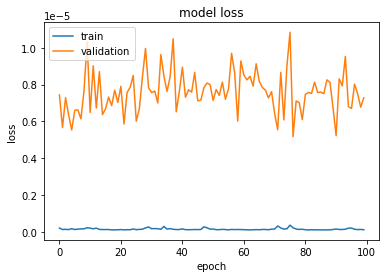

In [137]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [140]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

135.70134429570572

In [151]:
#Let's have a look at the 50 first rows to see how well we performed

comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

#We add a new indicator, the absolute difference
comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison.head(50)

,prediction,y_val,absolute_diff
0,128.129059,110,328.662774
1,-0.030351,0,0.000921
2,-0.030351,0,0.000921
3,16.235836,13,10.470635
4,-0.030351,0,0.000921
5,-0.030351,0,0.000921
6,-0.030351,0,0.000921
7,1.518845,3,2.193821
8,-0.030351,0,0.000921
9,1.662087,2,0.114185


In [152]:
comparaison.describe()

,prediction,y_val,absolute_diff
count,11526.000000,11526.000000,1.152600e+04
mean,9.346521,8.973712,1.357013e+02
std,53.537853,49.614875,4.117793e+03
min,-76.118454,0.000000,1.027007e-10
25%,-0.030351,0.000000,9.211872e-04
50%,-0.030351,0.000000,9.211872e-04
75%,2.573893,3.000000,4.557586e-01
max,2442.529053,2653.000000,2.750205e+05


In [154]:
comparaison['absolute_diff'].sum()/y_val.size

135.70134429570572

In [157]:
comparaison['prediction_rounded']=comparaison['prediction'].apply(lambda x: round(x))
comparaison['diff_rounded']=comparaison.apply(lambda x: (x['prediction_rounded']-x['y_val'])**2,axis=1)

In [158]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000
mean,9.346521,8.973712,1.357013e+02,9.368037,135.736682
std,53.537853,49.614875,4.117793e+03,53.532856,4117.957090
min,-76.118454,0.000000,1.027007e-10,-76.000000,0.000000
25%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000
50%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000
75%,2.573893,3.000000,4.557586e-01,3.000000,1.000000
max,2442.529053,2653.000000,2.750205e+05,2443.000000,274576.000000


In [159]:
def rounded_up_very_close(x):
    if (round(x)-x)**2<0.1:
        return round(x)
    return x
comparaison['prediction_rounded__very_close']=comparaison['prediction'].apply(lambda x: rounded_up_very_close(x))
comparaison['diff_rounded_close']=comparaison.apply(lambda x: (x['prediction_rounded__very_close']-x['y_val'])**2,axis=1)

In [160]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded,prediction_rounded__very_close,diff_rounded_close
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000,11526.000000,11526.000000
mean,9.346521,8.973712,1.357013e+02,9.368037,135.736682,9.366876,135.736081
std,53.537853,49.614875,4.117793e+03,53.532856,4117.957090,53.533234,4118.067455
min,-76.118454,0.000000,1.027007e-10,-76.000000,0.000000,-76.000000,0.000000
25%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000,0.000000,0.000000
50%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000,0.000000,0.000000
75%,2.573893,3.000000,4.557586e-01,3.000000,1.000000,2.573893,0.455759
max,2442.529053,2653.000000,2.750205e+05,2443.000000,274576.000000,2442.529053,275020.479538


In [163]:
def no_negatives(x):
    if x<0:
        return 0
    return x
comparaison['prediction_no_negatives']=comparaison['prediction'].apply(lambda x: no_negatives(x))
comparaison['diff_no_negatives']=comparaison.apply(lambda x: (x['prediction_no_negatives']-x['y_val'])**2,axis=1)

In [164]:
#Let's have a look at how well we improved the model with this improvement
comparaison.describe()

,prediction,y_val,absolute_diff,prediction_rounded,diff_rounded,prediction_rounded__very_close,diff_rounded_close,prediction_no_negatives,diff_no_negatives
count,11526.000000,11526.000000,1.152600e+04,11526.000000,11526.000000,11526.000000,11526.000000,11526.000000,11526.000000
mean,9.346521,8.973712,1.357013e+02,9.368037,135.736682,9.366876,135.736081,9.406384,133.962223
std,53.537853,49.614875,4.117793e+03,53.532856,4117.957090,53.533234,4118.067455,53.512027,4117.209648
min,-76.118454,0.000000,1.027007e-10,-76.000000,0.000000,-76.000000,0.000000,0.000000,0.000000
25%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.030351,0.000000,9.211872e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.573893,3.000000,4.557586e-01,3.000000,1.000000,2.573893,0.455759,2.573893,0.447983
max,2442.529053,2653.000000,2.750205e+05,2443.000000,274576.000000,2442.529053,275020.479538,2442.529053,275020.479538


# En dessous de ça on s'en balec

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


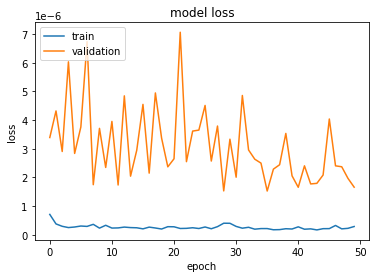

In [99]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


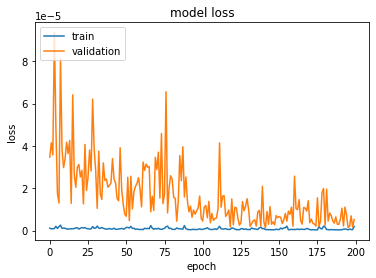

In [93]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


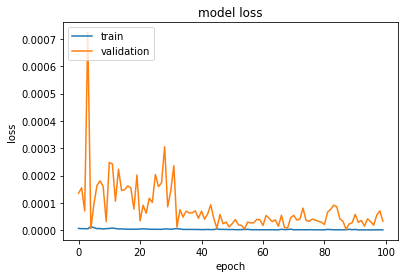

In [91]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


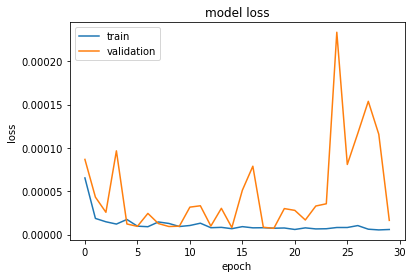

In [39]:
#6.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [100]:
prediction_unscaled=scaler_y.inverse_transform(predictions)
sklearn.metrics.mean_squared_error(y_val, prediction_unscaled)

262.723082996859

In [95]:
comparaison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

comparaison['absolute_diff']=comparaison.apply(lambda x: (x['prediction']-x['y_val'])**2,axis=1)
comparaison['relative_diff']=comparaison.apply(lambda x: x['absolute_diff']/(x['prediction']**2),axis=1)
comparaison.head()

,prediction,y_val,absolute_diff,relative_diff
0,141.599411,110,998.522776,0.049801
1,-0.141118,0,0.019914,1.000000
2,-0.141118,0,0.019914,1.000000
3,17.675032,13,21.855921,0.069960
4,-0.141118,0,0.019914,1.000000


In [96]:
comparaison.describe()

,prediction,y_val,absolute_diff,relative_diff
count,11526.000000,11526.000000,1.152600e+04,1.152600e+04
mean,9.712377,8.973712,4.149077e+02,1.013425e+02
std,62.783829,49.614875,1.574335e+04,5.956349e+03
min,-25.213772,0.000000,2.260115e-07,3.433703e-09
25%,-0.141118,0.000000,1.991431e-02,6.468449e-02
50%,-0.141118,0.000000,1.991431e-02,1.000000e+00
75%,2.796188,3.000000,6.021014e-01,1.000000e+00
max,3379.122314,2653.000000,1.418173e+06,5.883183e+05


In [150]:
comparaison['absolute_diff'].sum()/y_val.size

135.70134429570572

11526

# Research

In [11]:
#Could be a solution to solve the categorisation problem

df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')

categ_inst=df.categ_inst.astype("category").cat.codes
categ_inst=pd.Series(categ_inst)
categ_inst.unique()

array([4, 5, 3, 2, 1, 0], dtype=int8)

# Best Tuto ever pour Prediction Neural Network : https://towardsdatascience.com/regression-based-neural-networks-with-tensorflow-v2-0-predicting-average-daily-rates-e20fffa7ac9a

In [127]:
#5. Using the model
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=50, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/50
185/185 [==============================] - 0s 2ms/step - loss: 1.9528e-07 - mse: 1.9528e-07 - mae: 2.0972e-04 - val_loss: 7.7847e-06 - val_mse: 7.7847e-06 - val_mae: 3.0627e-04
Epoch 2/50
185/185 [==============================] - 0s 1ms/step - loss: 2.3775e-07 - mse: 2.3775e-07 - mae: 2.1955e-04 - val_loss: 7.5658e-06 - val_mse: 7.5658e-06 - val_mae: 2.0531e-04
Epoch 3/50
185/185 [==============================] - 0s 1ms/step - loss: 1.6042e-07 - mse: 1.6042e-07 - mae: 1.8620e-04 - val_loss: 8.4396e-06 - val_mse: 8.4396e-06 - val_mae: 2.5011e-04
Epoch 4/50
185/185 [==============================] - 0s 1ms/step - loss: 1.2152e-07 - mse: 1.2152e-07 - mae: 1.6218e-04 - val_loss: 5.8213e-06 - val_mse: 5.8213e-06 - val_mae: 2.1067e-04
Epoch 5/50
185/185 [==============================] - 0s 1ms/step - loss: 1.7923e-07 - mse: 1.7923e-07 - mae: 1.8849e-04 - val_loss: 7.8779e-06 - val_mse: 7.8779e-06 - val_mae: 3.1747e-04
Epoch 6/50
185/185 [==============================] - 0s 1ms